In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from arch import arch_model

In [48]:
df=pd.read_csv(r"C:\Users\Bogdan\OneDrive - University of Warwick\Desktop\Projects\Short-Term WTI Price Forecasting\Price prediction\Data.csv")
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
df['WTI'] = pd.to_numeric(df['WTI'])
df = df.sort_values(by='DATE', ascending=True)
df = df.set_index('DATE')
df = df.drop(columns=['Dubai','UK','Dubai Price', 'Texas', 'Brent'])
df = df.asfreq(pd.infer_freq(df.index))
df = df.resample('W').mean()
df['Pct_Change'] = df['WTI'].pct_change() * 100
df['Std_Dev'] = df['Pct_Change'].expanding().std() #expanding() = allows you to apply a statistical function cumulatively from the start of a dataset up to each point in the dataset
df = df.dropna()
df

C:\Users\Bogdan\AppData\Local\Temp\ipykernel_11024\559894366.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Pct_Change'] = df['WTI'].pct_change() * 100


,WTI,Pct_Change,Std_Dev
DATE,,,
2020-07-26,41.3380,1.893024,1.084939
2020-08-02,40.6860,-1.577241,1.739001
2020-08-09,41.1600,1.165020,1.495686
2020-08-16,42.0760,2.225462,1.516993
2020-08-23,42.7260,1.544824,1.389344
...,...,...,...
2024-08-11,75.8450,-1.635411,4.111263
2024-08-18,78.9975,4.156503,4.109715
2024-08-25,74.6780,-5.467895,4.119573


In [49]:
oil_predictions = {'DATE': ['2024-09-15', '2024-09-22', '2024-09-29', '2024-10-06', '2024-10-13', '2024-10-20'], 'Oil Predictions': ['70.369976', '69.420347', '69.369185', '70.379255', '70.313486', '69.672599']}
oil_df = pd.DataFrame(oil_predictions)
oil_df['DATE'] = pd.to_datetime(oil_df['DATE'])
oil_df = oil_df.set_index('DATE')
oil_df['Oil Predictions'] = pd.to_numeric(oil_df['Oil Predictions'])
last_value = df['WTI'].iloc[-1]
data = {'DATE': ['2024-09-08'], 'Oil Predictions': [last_value]}
the_stuff_to_add = pd.DataFrame(data)
the_stuff_to_add['DATE'] = pd.to_datetime(the_stuff_to_add['DATE'])
the_stuff_to_add = the_stuff_to_add.set_index('DATE')
oil_df = pd.concat([the_stuff_to_add, oil_df])
oil_df['Pct_Change'] = oil_df['Oil Predictions'].pct_change() * 100
oil_df = oil_df.dropna()
oil_df

,Oil Predictions,Pct_Change
DATE,,
2024-09-15,70.369976,-1.276689
2024-09-22,69.420347,-1.349480
2024-09-29,69.369185,-0.073699
2024-10-06,70.379255,1.456079
2024-10-13,70.313486,-0.093449
2024-10-20,69.672599,-0.911471


In [50]:
train_data = df['Pct_Change']
future_dates = pd.date_range(start=df.index[-1] + timedelta(weeks=1), periods=6, freq='W')
rolling_predictions = pd.Series(index=future_dates)

for i in rolling_predictions.index:
    model = arch_model(train_data, p=3, q=3)
    model_fit = model.fit()
    predictions = model_fit.forecast(horizon=1)
    rolling_predictions.loc[i] = np.sqrt(predictions.variance.values[-1]) #the output of predictions is an array that's why the .variance....
    train_data.loc[i] = oil_df.loc[i]['Pct_Change']

rolling_predictions

Iteration:      1,   Func. Count:     10,   Neg. LLF: 695.5761660980947
Iteration:      2,   Func. Count:     21,   Neg. LLF: 781.8971386997991
Iteration:      3,   Func. Count:     32,   Neg. LLF: 611.701663560983
Iteration:      4,   Func. Count:     42,   Neg. LLF: 616.6083754432324
Iteration:      5,   Func. Count:     53,   Neg. LLF: 603.7643240705531
Iteration:      6,   Func. Count:     62,   Neg. LLF: 603.8422300480565
Iteration:      7,   Func. Count:     72,   Neg. LLF: 603.677860447284
Iteration:      8,   Func. Count:     82,   Neg. LLF: 603.4351183159056
Iteration:      9,   Func. Count:     91,   Neg. LLF: 603.403519657174
Iteration:     10,   Func. Count:    100,   Neg. LLF: 603.395381333638
Iteration:     11,   Func. Count:    109,   Neg. LLF: 603.3949204220072
Iteration:     12,   Func. Count:    118,   Neg. LLF: 603.394911921983
Iteration:     13,   Func. Count:    127,   Neg. LLF: 605.3539333010542
Optimization terminated successfully    (Exit mode 0)
            Cur

2024-09-15    4.044299
2024-09-22    3.673101
2024-09-29    3.284275
2024-10-06    3.795405
2024-10-13    3.480619
2024-10-20    3.121343
Freq: W-SUN, dtype: float64

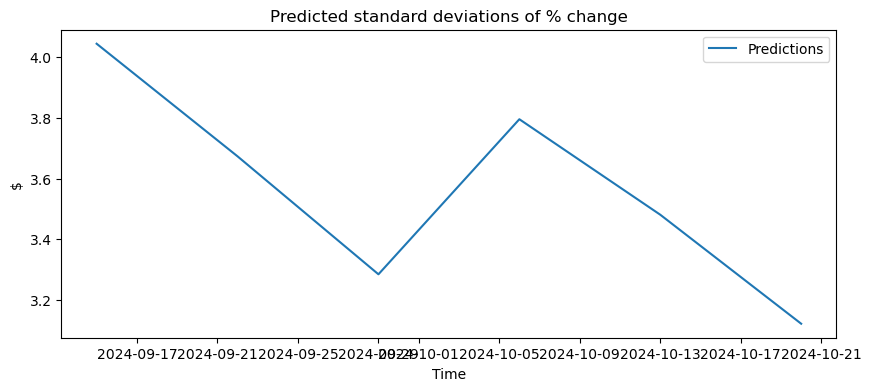

In [52]:
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions, label='Predictions')
plt.title('Predicted standard deviations of % change')
plt.ylabel('$')
plt.xlabel('Time')
plt.legend()